**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

# *Title* 

Linear and Logistic regression in classification of music genres




## Abstract

After applying some cleaning of the data, removing columns with the same value, we managed to apply standardization or normalization and watched the difference with two different algorithms, logistic regression and linear regression.

Before doing that, we plotted the error for PCA and decided to keep 220 features, but even 200 features only is a good option since the error is very small.

We found out that the difference with Linear Regression and Logistic Regression is very little, the major difference is between standardization and normalization, with the latter being the most effective.

## 1. Introduction

The task is to build a predictor that can classify songs into 10 different music genres using features suchs as Rhythm Pattern, Chorma and MFCCs obtained from a sample of the song audio signal.

This objective is difficult, because the difference between different musical styles sometimes may be very subtle, and that is why the task is being simplified using only 10 music genres.

Our mission is important because it has many application for automatical genre recognition in applications such as Spotify, Shazam, SoundCloud etc. or simply having a database that can shuffle the songs based on the genre on your own media centre.

Although there are already some good projects with the same aim such as "DeepSound" that uses Deep Neural Networks, we decided to take a different approach and we tested different algorithms suchs as Linear and Logistic Regression, because we thought that they could do a pretty decent job without taking too much CPU time.





## 2. Data analysis

In [111]:
from math import log
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import itertools

#!pip install -U -q PyDrive

Train data shape is  (4363, 264)
Train label shape is  (4363, 1)
Test data shape is  (6544, 264)
Label 1 has 2178 songs
Label 2 has 618 songs
Label 3 has 326 songs
Label 4 has 253 songs
Label 5 has 214 songs
Label 6 has 260 songs
Label 7 has 141 songs
Label 8 has 195 songs
Label 9 has 92 songs
Label 10 has 86 songs


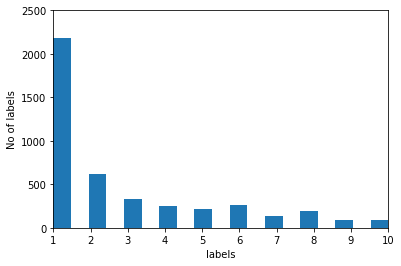

As we can see from the instogram, the train data is strongly unbalanced
toward Label 1, but oversampling didn't improve our accuracy so we decided
to remove it from the code.


In [112]:
#### GET DATA

df_data = pd.read_csv('data/train_data.csv', header=None)
print("Train data shape is ", df_data.shape)

df_labels = pd.read_csv('data/train_labels.csv', header=None)
print("Train label shape is ", df_labels.shape)

df_test_data = pd.read_csv('data/test_data.csv', header=None)
print("Test data shape is ", df_test_data.shape)

grouped = df_labels.groupby(by=0)
for name, group in grouped:
    print("Label %d has %d songs" % (name, group.size))

labels = df_labels.values

graph = plt.hist(labels, bins=19)

plt.xlim((1, 10))
plt.ylim((0,2500))
plt.ylabel('No of labels')
plt.xlabel('labels')

plt.show(graph)

print("As we can see from the instogram, the train data is strongly unbalanced\n" 
      "toward Label 1, but oversampling didn't improve our accuracy so we decided\n" 
      "to remove it from the code.")

In [113]:
###### DATA

def get_train_set_splited(df_train_data, df_train_labels, test_size = 1./7.):
    df_train_set, df_val_set, df_train_lbl, df_val_lbl = train_test_split(df_train_data, df_train_labels, test_size = test_size, random_state = 0)
    return df_train_set.values, df_train_lbl.values, df_val_set.values, df_val_lbl.values


def remove_columns(df_data, indexes):
    new_values = np.delete(df_data.values, indexes, 1)
    return pd.DataFrame(new_values)

In [114]:
######### PCA

def make_tuples(first_array, second_array):
    n = len(first_array)
    
    tuples = []
    for i in range(n):
        tuples.append((first_array[i], second_array[i]))
        
    return tuples

def get_pca(raw_data, number_of_components):
    N = raw_data.shape[0]
    raw_data_transpose = raw_data.transpose()
    Q = (1./N) * np.dot(raw_data_transpose, raw_data)

    eigenvalues, eigenvectors = la.eig(Q)
    
    tuples = make_tuples(eigenvalues, eigenvectors.transpose())
    ordered_tuples = sorted(tuples, reverse = True, key = lambda item: item[0])
    
    pca = []
    for i in range(number_of_components):
        pca.append(ordered_tuples[i][1])
        
    pca = np.array(pca)
    
    map_tuples_to_eigenvalues = map(lambda item: item[0], ordered_tuples)
    
    return pca.real, np.array(list(map_tuples_to_eigenvalues))

def plot_pca_error(eigvalues, number_of_components):
    x = range(1, number_of_components + 1)
    errors = [sum(eigvalues[d:]) for d in x]
    plt.plot(x, errors)
    plt.xlabel('Number of principal components $d$')
    plt.ylabel('Reconstruction error $\mathcal{E}$')
    plt.title('Number of principal components vs the reconstruction error')
    plt.show()
      

In [115]:
###### LABELS

def get_labeled_array(label, labels):
    N = labels.shape[0]
    y = np.zeros((N, 1))
        
    for index in range(N):
        if labels[index][0] == label: 
            y[index][0] = 1
    
    return y

def get_predicted_labels(probabilities):
    N = probabilities.shape[0]
    predicted_labels = np.zeros((N, 1))

    for i in range(N):
        index_of_max_value = np.argmax(probabilities[i])
        predicted_labels[i] = index_of_max_value + 1
        
    return predicted_labels

def calculate_accuracy(actual_labels, predicted_labels):
    width, height = actual_labels.shape
    result = actual_labels - predicted_labels
    zeros = np.count_nonzero(result == 0)
    N = width * height
    accuracy = zeros / N
    return accuracy * 100
  
def calculate_log_loss_accuracy(actual_labels, probabilites):
    N = actual_labels.size    
    tmp_sum = 0
    
    for i in range(N):
      tmp_sum += log(probabilites[i][int(actual_labels[i]) - 1]) 
    
    
    log_loss_accuracy = tmp_sum * -1/N
    return log_loss_accuracy

In [116]:
######### LOGISTIC REGRESSION

def sigmoid(z):
    return np.divide(1, (1 + np.exp((-1) * z)))


def derivative_sigmoid(z):
    return np.multiply(np.exp(-z), np.power(sigmoid(z), 2))


def gradient_logistic_regression(X, y, w):
    N = X.shape[0]
    z = np.dot(X, w)
    sigmoid_z = sigmoid(z)
    derivative_sigmoid_z = derivative_sigmoid(z)
    
    first_term = np.multiply(y, np.divide(derivative_sigmoid(z), sigmoid(z)))
    second_term = np.multiply(1 - y, np.divide((-1) * derivative_sigmoid(z), (1 - sigmoid(z))))
    
    sum = first_term + second_term
    return (-1 / N) * np.dot(np.transpose(X), sum)


def empirical_risk_logistic_regression(X, y, w):
    z = np.dot(X, w)

    first_term = np.multiply(y, np.log(sigmoid(z)))
    second_term = np.multiply(1 - y, np.log(1 - sigmoid(z)))
    
    sum = first_term + second_term
    return (-1) * np.mean(sum)


def predicted_probabilities_regression(X, w):
    y = np.dot(X, w)
    return sigmoid(y)

In [117]:
###### LINEAR REGRESSION

def gradient_linear_regression(X, y, w):
    N = X.shape[0]
    X_transposed = np.transpose(X)
    final_matrix = np.dot(X_transposed, y - np.dot(X, w))
    gradient = (-2. / N) * final_matrix
    return gradient

def empirical_risk_linear_regression(X, y, w):
    sum = np.power((y - np.dot(X, w)), 2)
    return np.mean(sum)

In [118]:
###### REGRESSION

def regression(X, y, step_size, iterations, gradient, empirical_risk):
    d = X.shape[1]
    w = np.zeros((d, 1))
    loss_list = []

    for i in range(iterations):
        grad = gradient(X, y, w)
        w = w - step_size * grad
        loss_list.append(empirical_risk(X, y, w))

    return loss_list, w

def get_w_opt_regression(X, train_labels_values, gradient, empirical_risk, step_size = 1e-5, iterations = 3000):
    N = X.shape[0]
    d = X.shape[1]
    labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    quantity_of_labels = len(labels)

    y = np.zeros((N, quantity_of_labels))
    w = np.zeros((d, quantity_of_labels))
    
    for i in range(quantity_of_labels):
        y_subproblem = get_labeled_array(i+1, train_labels_values)
        loss_list_subproblem, w_subproblem = regression(X, y_subproblem, step_size, iterations, gradient, empirical_risk)
    
        w[:, i:i+1] = w_subproblem
        y[:, i:i+1] = y_subproblem
    
    return w

In [119]:
#### CLEAN DATA
columns_to_remove = [216, 217, 218, 219] #These columns have all the same value
df_data = remove_columns(df_data, columns_to_remove)
df_test_data = remove_columns(df_test_data, columns_to_remove)

train_data, train_labels, val_data, val_labels = get_train_set_splited(df_data, df_labels, test_size = 0.25)

In [120]:
#### STANDARDIZATION
scaler = StandardScaler()

df_train_data = pd.DataFrame(train_data)

scaler.fit(df_train_data)

X = scaler.transform(df_train_data)
val_data = scaler.transform(pd.DataFrame(val_data))
test_data = scaler.transform(df_test_data)
confusion_matrix_data = scaler.transform(df_data)

In [108]:
#### NORMALIZATION
scaler = MinMaxScaler()

df_train_data = pd.DataFrame(train_data)

scaler.fit(df_train_data)

X = scaler.transform(df_train_data)
val_data = scaler.transform(pd.DataFrame(val_data))
test_data = scaler.transform(df_test_data)
confusion_matrix_data = scaler.transform(df_data)

In [121]:
#### APPLY PCA
number_of_pca_components = 220

pca, eigenvalues = get_pca(X, number_of_pca_components)
X = np.dot(X, pca.transpose())
val_data = np.dot(val_data, pca.transpose())
test_data = np.dot(test_data, pca.transpose())
confusion_matrix_data = np.dot(confusion_matrix_data, pca.transpose())

In [110]:
#### RUN LOGISTIC REGRESSION TIME NEEDED ~2 mins
w_opt = get_w_opt_regression(X, train_labels, gradient_logistic_regression, empirical_risk_logistic_regression,
                             step_size = 0.1, iterations = 3000)

probabilities = predicted_probabilities_regression(val_data, w_opt)
predicted_labels = get_predicted_labels(probabilities)
accuracy = calculate_accuracy(val_labels, predicted_labels)
log_loss_accuracy = calculate_log_loss_accuracy(val_labels, probabilities)

print("Accuracy of logistic regression is ", accuracy)
print("Log loss of logistic regression is ", log_loss_accuracy)

Accuracy of logistic regression is  63.06141154903758
Log loss of logistic regression is  1.2410571949118583


In [122]:
#### RUN LINEAR REGRESSION TIME NEEDED ~40 secs
w_opt = get_w_opt_regression(X, train_labels, gradient_linear_regression, empirical_risk_linear_regression,
                             step_size = 0.01, iterations = 3000)

probabilities = predicted_probabilities_regression(val_data, w_opt)
predicted_labels = get_predicted_labels(probabilities)
accuracy = calculate_accuracy(val_labels, predicted_labels)
log_loss_accuracy = calculate_log_loss_accuracy(val_labels, probabilities)

print("Accuracy of linear regression is ", accuracy)
print("Log loss of linear regression is ", log_loss_accuracy)

Accuracy of linear regression is  58.57011915673694
Log loss of linear regression is  0.6017758393977037


In [14]:
#### PROBABILITIES FOR LOGISTIC REGRESSION
test_probabilities = predicted_probabilities_regression(test_data, w_opt)

In [0]:
#### PROBABILITIES FOR LINEAR REGRESSION
test_probabilities = predicted_probabilities_regression(test_data, w_opt)

In [15]:
#### GETTING PREDICTED LABELS FOR TEST DATA
predicted_test_labels = get_predicted_labels(test_probabilities).astype(int)


#### FILE FOR ACCURACY CHALLENGE
ids = np.arange(1, len(predicted_test_labels) + 1)
df_submission_accuracy = pd.DataFrame({"Sample_id" : ids, "Sample_label" : predicted_test_labels.flatten()})
df_submission_accuracy.to_csv("accuracy_challenge.csv", index=False)

#### FILE FOR LOGLOSS CHALLENGE
ids = np.arange(1, len(predicted_test_labels) + 1)
df_submission_logloss = pd.DataFrame(
    {
        "Sample_id": ids,
        "Class_1": test_probabilities[:,0],
        "Class_2": test_probabilities[:,1],
        "Class_3": test_probabilities[:,2],
        "Class_4": test_probabilities[:,3],
        "Class_5": test_probabilities[:,4],
        "Class_6": test_probabilities[:,5],
        "Class_7": test_probabilities[:,6],
        "Class_8": test_probabilities[:,7],
        "Class_9": test_probabilities[:,8],
        "Class_10": test_probabilities[:,9]
    }
)
df_submission_logloss.to_csv("logloss_challenge.csv", index=False)

## 3. Methods and experiments

Even if there are some functions that are ready out of the box from scikit-learn for logistic and linear regression, we decided to implement our own version; this decision gave us a tiny penalty in the accuracy on kaggle, but it is much better in order to have a clear view on how the algorithms actually work.

We chose linear and logistic regression because they are easy to implement, and they are not that bad in terms of accuracy.

To evaluate and compare accuracy we tried different runs mixing standardization and normalization with Linear and Logistic Regression



![Imgur](https://i.imgur.com/P1LlLHE.png)


## 4. Results

Speaking of how our accuracy and log-loss compare in kaggle in respect to the training data set, they are quite similar only for the accuracy, with a slight difference of 1 point; with the logloss we have a huge difference but it is performing better on kaggle than our train set, so it is something positive.

ACCURACY LOGISTIC REGRESSION WITH NORMALIZATION: 63.06141
ACCURACY LOGISTIC REGRESSION WITH STANDARDIZATION : 58.38680
ACCURACY LINEAR REGRESSION WITH NORMALIZATION: 62.32814
ACCURACY LINEAR REGRESSION WITH STANDARDIZATION : 58.57012
LOG LOSS LOGISTIC REGRESSION WITH NORMALIZATION : 1.24106
LOG LOSS LOGISTIC REGRESSION WITH STANDARDIZATION : 0.43905
LOG LOSS LINEAR REGRESSION WITH NORMALIZATION: 0.50422
LOG LOSS LINEAR REGRESSION WITH STANDARDIZATION: 0.60178 



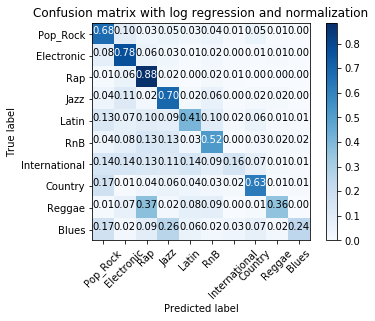

In [130]:
#Confusion matrix ...

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
   
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

print("ACCURACY LOGISTIC REGRESSION WITH NORMALIZATION: 63.06141")
print("ACCURACY LOGISTIC REGRESSION WITH STANDARDIZATION : 58.38680")
print("ACCURACY LINEAR REGRESSION WITH NORMALIZATION: 62.32814")   
print("ACCURACY LINEAR REGRESSION WITH STANDARDIZATION : 58.57012") 

print("LOG LOSS LOGISTIC REGRESSION WITH NORMALIZATION : 1.24106")
print("LOG LOSS LOGISTIC REGRESSION WITH STANDARDIZATION : 0.43905")
print("LOG LOSS LINEAR REGRESSION WITH NORMALIZATION: 0.50422")   
print("LOG LOSS LINEAR REGRESSION WITH STANDARDIZATION: 0.60178 \n")   

class_names = ['Pop_Rock', 'Electronic', 'Rap', 'Jazz', 'Latin', 'RnB', 'International', 'Country', 'Reggae', 'Blues']
    
confusion_matrix_data_prob = predicted_probabilities_regression(confusion_matrix_data, w_opt) 
confusion_matrix_predicted_labels = get_predicted_labels(confusion_matrix_data_prob)

# Compute confusion matrix
cnf_matrix = confusion_matrix(df_labels, confusion_matrix_predicted_labels)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, classes=class_names, title='Confusion matrix with log regression and normalization')

plt.show()


## 5. Discussion/Conclusions

We obtained the best result with Logistic Regression and Normalization, with a 62% accuracy on kaggle.
We maybe could have improved the result by a ~5%/~10% using decision trees or neural networks and doing some more cleaning of the data.

A future improvement could be understanding better what exactly are the features, to spot more outliers and increase the quality of the training; another improvement could be finding or building a nice oversampling algorithm, because SMOTE alone could generate synthethic new data, but since they will differ a little from one to another, they could jump from another genre to another, and we wanted a more clean oversampling. 

The study answered our question, Logistic Regression seems to work better but the difference is very little (~0.7 points difference on our training data).





## 6. References

DeepSound -> http://deepsound.io/music_genre_recognition.html